In [32]:
import pandas as pd
import nltk
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [56]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

EDA

In [88]:
df = pd.read_csv('labeled.csv')

In [7]:
df.shape

(14412, 2)

In [89]:
df['toxic'] = df['toxic'].astype(int) #меняем тип c float на int

In [12]:
df['toxic'].value_counts() #смотрим распределение классов

0    9586
1    4826
Name: toxic, dtype: int64

In [ ]:
for row in df[df['toxic']==0]['comment'].head(5): #примеры данных
    print (row)

In [91]:
train_df, test_df = train_test_split(df, test_size = 500) #берем 500 сэмплов для теста

In [92]:
test_df.shape

(500, 2)

In [93]:
test_df["toxic"].value_counts()

0    335
1    165
Name: toxic, dtype: int64

In [47]:
#Предобработка текста
sentence_example = df.iloc[1]["comment"] 
tokens = word_tokenize(sentence_example, language="russian") #токенизация
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation] #удаление пунктуации
russian_stop_words = stopwords.words('russian') #стопслов
tokens_without_stop_words_and_punctuation = [i for i in tokens if i not in string.punctuation] #удаление стопслов
snowball = SnowballStemmer(language='russian') #стемминг
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [ ]:
print(f"Текст: {sentence_example}")
print("––––––––––––")
print(f"Текст: {tokens}")
print("––––––––––––")
print(f"Текст: {tokens_without_punctuation}")
print("––––––––––––")
print(f"Текст: {russian_stop_words}")
print("––––––––––––")
print(f"Текст: {tokens_without_stop_words_and_punctuation}")
print("––––––––––––")
print(f"Текст: {snowball}")
print("––––––––––––")
print(f"Текст: {stemmed_tokens}")


In [94]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words('russian') #стопслов

def tokenize_sentence(sentence = str, remove_stop_words: bool = True):
    tokens = word_tokenize (sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words: 
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [95]:
vectorizer = TfidfVectorizer (tokenizer = lambda x: tokenize_sentence(x, remove_stop_words=True)) #tf-idf векторайзер. статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.

In [96]:
features = vectorizer.fit_transform(train_df["comment"]) #обучение векторайзера с возвратом фич . Подготовка фич

In [69]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df['toxic']) #обучение модели

LogisticRegression(random_state=0)

In [72]:
model.predict(features[2])

array([1])

In [98]:
model_pipeline = Pipeline([
    ("vecorizer", TfidfVectorizer (tokenizer = lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0)
)
])
# соединяем в подготовку фич и модель

In [99]:
model_pipeline.fit(train_df["comment"], train_df["toxic"]) #обучаем модель с использованием пайплайна, передаем фичи и лейблы

Pipeline(steps=[('vecorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fb37b1e8040>)),
                ('model', LogisticRegression(random_state=0))])

In [77]:
model_pipeline.predict(["все же хорошо"])

array([0])

In [78]:
#показатели для baseline

0.9027777777777778

In [100]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.9296875

In [101]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.7212121212121212

In [ ]:
#показатели для baseline

In [128]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"].astype(str))[:, 1])
#данные для построения графика по показателям модели

/opt/anaconda3/envs/Datascience/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


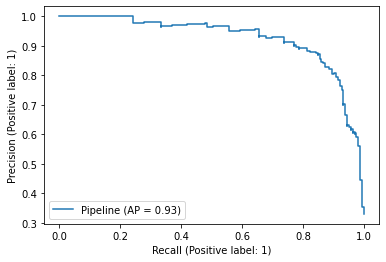

In [129]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])

In [126]:
plot_precision_recall_curve

<function sklearn.metrics._plot.precision_recall_curve.plot_precision_recall_curve(estimator, X, y, *, sample_weight=None, response_method='auto', name=None, ax=None, pos_label=None, **kwargs)>

In [131]:
np.where(prec > 0.95)

(array([387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399,
        404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
        417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
        430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
        443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
        456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
        469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
        482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
        495, 496, 497, 498, 499, 500]),)

In [132]:
precision_score(y_true=test_df["toxic"], \
                                               y_pred=model_pipeline.predict_proba([str (item) for item in test_df["comment"]])[:,1] > thresholds[387])
#данные для построения графика по показателям модели

0.9553571428571429

In [135]:
recall_score(y_true=test_df["toxic"], \
                                               y_pred=model_pipeline.predict_proba([str (item) for item in test_df["comment"]])[:,1] > thresholds[387])

0.6484848484848484

In [ ]:
#Подбор гиперпараметров. Перебор вариантов регулиризации

In [136]:
grid_pipeline = Pipeline([
    ("vecorizer", TfidfVectorizer (tokenizer = lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
         LogisticRegression(random_state=0),
         param_grid={'C':[0.1, 1, 10.]}, #указываем что будем перебирать 
         cv=3,
             verbose=4
     )
)
])

In [137]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.686 total time=   0.1s
[CV 2/3] END .............................C=0.1;, score=0.687 total time=   0.1s
[CV 3/3] END .............................C=0.1;, score=0.686 total time=   0.1s
[CV 1/3] END ...............................C=1;, score=0.832 total time=   0.2s
[CV 2/3] END ...............................C=1;, score=0.832 total time=   0.2s
[CV 3/3] END ...............................C=1;, score=0.840 total time=   0.4s


/opt/anaconda3/envs/Datascience/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ............................C=10.0;, score=0.859 total time=   0.4s


/opt/anaconda3/envs/Datascience/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ............................C=10.0;, score=0.862 total time=   0.4s


/opt/anaconda3/envs/Datascience/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ............................C=10.0;, score=0.867 total time=   0.4s


/opt/anaconda3/envs/Datascience/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vecorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fb36cc0f4c0>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [138]:
model_pipeline_c_10 = Pipeline([
    ("vecorizer", TfidfVectorizer (tokenizer = lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.)
)
])

In [139]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

/opt/anaconda3/envs/Datascience/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vecorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fb367c478b0>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [142]:
prec_10, rec_10, threshold_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"].astype(str))[:, 1])

In [143]:
precision_score(y_true=test_df["toxic"], \
                                               y_pred=model_pipeline_c_10.predict_proba([str (item) for item in test_df["comment"]])[:,1] > threshold_10[387])
#данные для построения графика по показателям модели

0.9553571428571429

In [144]:
recall_score(y_true=test_df["toxic"], \
                                               y_pred=model_pipeline_c_10.predict_proba([str (item) for item in test_df["comment"]])[:,1] > threshold_10[387])
#данные для построения графика по показателям модели

0.6484848484848484